# Portfolio management

Como vamos simular a performance em um mês que já aconteceu (jan/2024) vamos realizar a previsão de crescimento de cada empresa em cada dia desse mês 

Caso fosse um senário real bastava recolher os dados no final de cada dia e diariamente faziamos a previsão do modelo

In [3]:
import pandas as pd
import random
import matplotlib.pyplot as plt
import pickle
import os

pd.options.mode.copy_on_write = True

def save_pkl(data, path):
    try:
        with open(path, "wb") as saved_data:
            pickle.dump(data, saved_data)
    except:
        print('Fail to save data')

def load_pkl(path):
    try:
        with open(path, "rb") as loaded_data:
            to_return = pickle.load(loaded_data)
        return to_return
    except:
        print('Fail to load data')
        return None
    
index_dates = ['start','2024-01-02', '2024-01-03', '2024-01-04', '2024-01-05', '2024-01-08',
    '2024-01-09', '2024-01-10', '2024-01-11', '2024-01-12', '2024-01-16',
    '2024-01-17', '2024-01-18', '2024-01-19', '2024-01-22', '2024-01-23',
    '2024-01-24', '2024-01-25', '2024-01-26', '2024-01-29', '2024-01-30']

### Previsão do modelo

Vamos prever qual será o crescimento de cada empresa no final do dia em relação ao início

In [6]:
path_test = "data/simulation/"
test_df = os.listdir(path_test)
models = os.listdir("models_deviation")

if not os.path.exists("data/predict/"):
    os.mkdir("data/predict/")

predictores = ["day_of_week", "daily_return_1", "daily_return_2", "daily_return_3", "weekly_return", "volatility_prev_day","deviation"]


df_prev = pd.DataFrame()
for i in range(len(test_df)):
    data_prever =  pd.read_csv(path_test+test_df[i],index_col=0)
    model = load_pkl(f"models_deviation/{models[i+1]}")
    
    
    for company in data_prever["ticker"].unique():
        # para manter a data da previsao do modelo
        index_dates = ['2024-01-02', '2024-01-03', '2024-01-04', '2024-01-05', '2024-01-08',
       '2024-01-09', '2024-01-10', '2024-01-11', '2024-01-12', '2024-01-16',
       '2024-01-17', '2024-01-18', '2024-01-19', '2024-01-22', '2024-01-23',
       '2024-01-24', '2024-01-25', '2024-01-26', '2024-01-29', '2024-01-30']
        
        data = data_prever[data_prever["ticker"] == company]
        predicted = model.predict(data[predictores])
        
        df = pd.DataFrame({'ticker': [company] * len(index_dates),
                           'predict': predicted,
                           'real': data["target"].to_numpy(),
                           'sector':test_df[i].split(".")[0]},
                          index=pd.to_datetime(index_dates))
        df_prev = pd.concat([df_prev,df])

df_prev.to_csv(f"data/predict/all_join.csv")
    

## Simular Monte Carlo

In [17]:
predicted_returns = pd.read_csv("data/predict/all_join.csv",index_col=0)

initial_budget = 10000
transaction_fee = 1
max_stocks_per_day = 100

# num de simulacoes
num_simulations = 2500

def simulate_strategy(predicted_returns, budget, max_stocks, transaction_fee):
    real_daily_values = []
    real_cash = budget
    
    pred_daily_values = []
    cash = budget
    
    history_bought_stocks = {}

    days_to_simulate = predicted_returns.index.unique()
    for i in range(len(days_to_simulate)):
        day = days_to_simulate[i]   
        daily_bought = 0

        portfolio = {}  # guardar a quantidade de stock comprado
        day_info = predicted_returns[predicted_returns.index == day]

        # apenas manter a 30 empresas que prevemos maior crescimento para escolher baseado em pesos em qual investir
        day_info = day_info.sort_values(by='predict', ascending=False).iloc[:20] 

        # cria pesos para tornar mais provavel escolher os stocks com maior previsao de crescimento
        day_info['weights'] = day_info['predict'] / day_info['predict'].sum()

        # Get unique tickers for buying
        buy_candidates = day_info[day_info['predict'] > 0][['ticker', 'weights']].copy()
        
        
        
        # comprar stocks no inicio do dia caso ainda tenha cash disponivel
        for j in range(6):
            if cash < 600:
                break
            elif cash//3 <= 600: 
                price = 600
            else: 
                price = random.randint(600,int(cash//3))
            
            # company = random.choice(buy_candidates)
            company = random.choices(buy_candidates['ticker'].tolist(), weights=buy_candidates['weights'].tolist(), k=1)[0]

            # remover a empresa das disponiveis pois ja comprou 
            buy_candidates = buy_candidates.loc[buy_candidates['ticker'] != company]


            cash -= price
            real_cash -= price
            portfolio[company] = (price - transaction_fee)

            daily_bought += 1
            if daily_bought >= max_stocks:
                break  # atingimos o limite diario

        history_bought_stocks[day] = portfolio
     
        # valor real usado para atualizar o cash e o valor do investimento
        # como nao fazemos a previsao se o stock vai subir ou descer entre dias, vamos vender tudo hoje no final do dia
 
        for company in portfolio.keys():
            real_change = round(day_info.loc[day_info["ticker"] == company, "real"].to_numpy()[0],6)
            real_cash += round(portfolio[company] * (real_change + 1),2)

            pred_change = round(day_info.loc[day_info["ticker"] == company, "predict"].to_numpy()[0],6)
            cash += round(portfolio[company] * (pred_change + 1),2)
        del portfolio

        # guardar o valor do portfolio on final do dia
        real_daily_values.append(real_cash)
        pred_daily_values.append(cash)


    return real_daily_values[-1], real_daily_values, pred_daily_values[-1], pred_daily_values, history_bought_stocks


# Run Monte Carlo Simulations
real_results = []
real_daily_portfolios = []
pred_results = []
pred_daily_portfolios = []
history_stocks = []

for _ in range(num_simulations):
    real_final_value, real_daily_value, pred_final_value, pred_daily_value, history = simulate_strategy(predicted_returns, initial_budget, max_stocks_per_day, transaction_fee)

    real_results.append(real_final_value)
    real_daily_portfolios.append(real_daily_value)
    pred_results.append(pred_final_value)
    pred_daily_portfolios.append(pred_daily_value)
    history_stocks.append(history)


## Analisar Resultados

Vamos analisar qual foi a melhor simulação com base nos retornos previstos, isto é, 
- Se os retornos previstos pelos modelos fossem os reais qual era o valor final do portfólio 
- e qual a comparação com a realidade se escolhessemos as ações tomadas nessa simulação, comprar os mesmo stocks e a mesma quantidade nos mesmos dias

In [18]:
# Analyze Results
best_result = max(pred_results)
best_strategy_index = pred_results.index(best_result)

As ações compradas diariamente

In [19]:
print("Quais Stocks comparar e quantidade por dia")
print("<lembrar, comprar no inicio do dia e vender no final>")
for day, trades in history_stocks[best_strategy_index].items():
    print(f"{day}: {trades}")

Quais Stocks comparar e quantidade por dia
<lembrar, comprar no inicio do dia e vender no final>
2024-01-02: {'TSLA': 2762, 'ENPH': 980, 'AMD': 1363, 'APA': 1069, 'LRCX': 604, 'ANET': 1061}
2024-01-03: {'CI': 852, 'MRNA': 2437, 'OKE': 2143, 'FSLR': 795, 'COP': 856, 'ENPH': 632}
2024-01-04: {'ENPH': 1142, 'MRNA': 2238, 'TSLA': 1062, 'ZBRA': 807, 'ODFL': 1178, 'VRTX': 1182}
2024-01-05: {'GNRC': 3270, 'MPC': 1946, 'CVX': 971, 'ULTA': 1110, 'ALGN': 720, 'BKR': 613}
2024-01-08: {'OXY': 2253, 'ZBRA': 1113, 'HES': 1653, 'PLTR': 688, 'ENPH': 1124, 'AVGO': 1023}
2024-01-09: {'VLO': 3063, 'HAL': 948, 'COP': 1920, 'EQT': 918, 'TRGP': 961, 'CTRA': 704}
2024-01-10: {'MU': 1630, 'CI': 1353, 'ISRG': 2071, 'ALGN': 692, 'APA': 1176, 'TPL': 1045}
2024-01-11: {'VRTX': 1173, 'WST': 1045, 'IDXX': 1841, 'FANG': 742, 'EW': 1418, 'ALGN': 1085}
2024-01-12: {'CVX': 2931, 'COP': 1701, 'CTLT': 1170, 'ALGN': 1184, 'HAL': 688, 'IDXX': 771}
2024-01-16: {'ENPH': 1555, 'APA': 2795, 'OXY': 1794, 'DAL': 740, 'CDW': 970,

### Comparação entre o previsto e o real

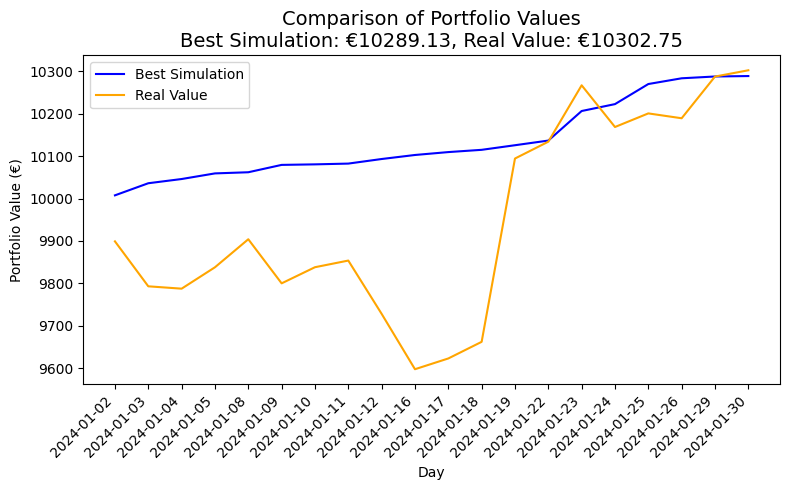

In [20]:

plt.figure(figsize=(8, 5))

plt.plot(pred_daily_portfolios[best_strategy_index], label="Best Simulation", color="blue")
plt.plot(real_daily_portfolios[best_strategy_index], label="Real Value", color="orange")

plt.title(f"Comparison of Portfolio Values\nBest Simulation: €{best_result:.2f}, Real Value: €{real_results[best_strategy_index]:.2f}", fontsize=14)
plt.xlabel("Day")
plt.ylabel("Portfolio Value (€)")
plt.xticks(range(len(index_dates)), index_dates, rotation=45, ha='right')
plt.legend()

plt.tight_layout()
plt.show()

### As simulações e o valor real

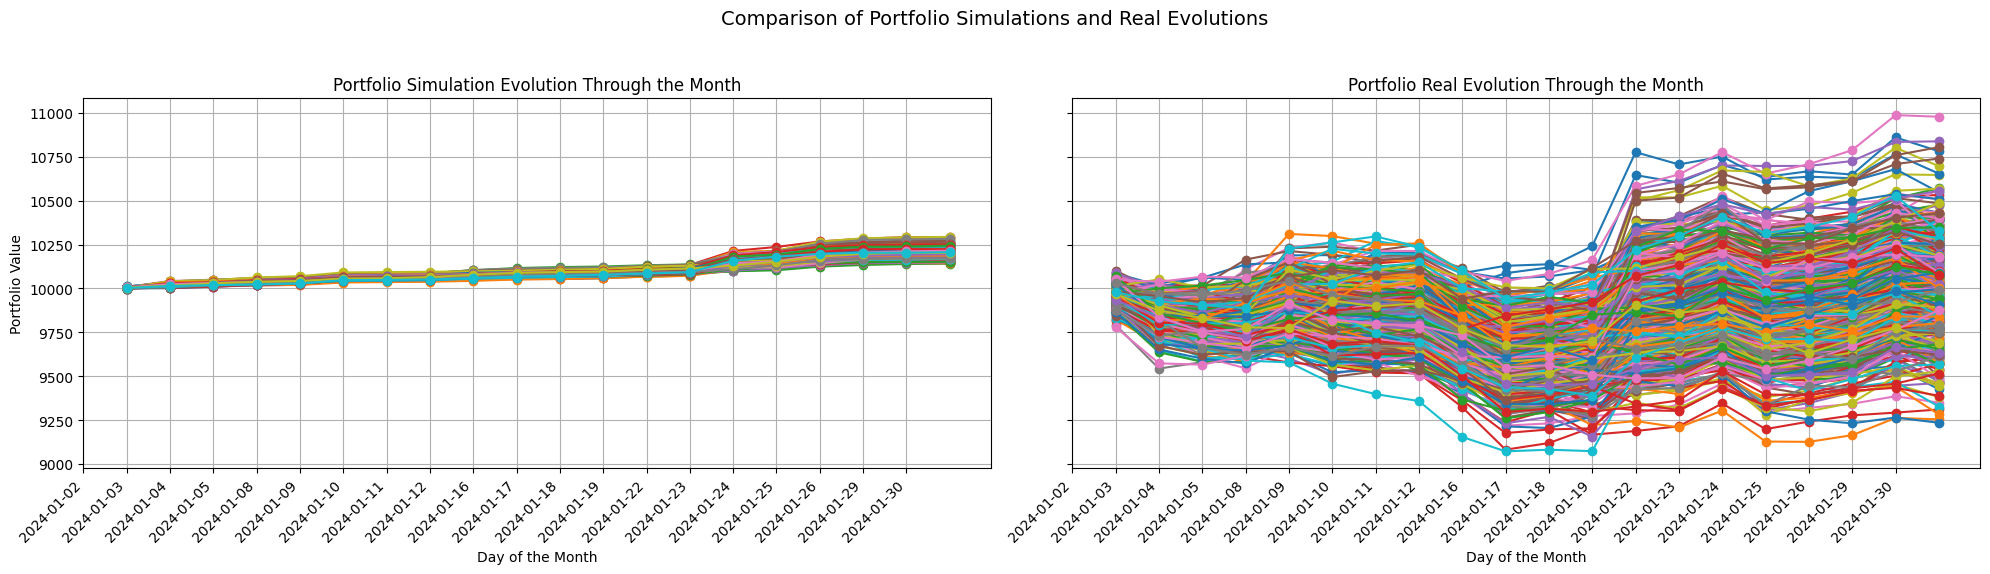

In [16]:

days = range(1, len(pred_daily_portfolios[0]) + 1)
fig, axes = plt.subplots(1, 2, figsize=(20, 6), sharex=True, sharey=True)


for i, portfolio in enumerate(pred_daily_portfolios):
    axes[0].plot(days, portfolio, label=f'Portfolio {i + 1}', marker='o')
axes[0].set_title("Portfolio Simulation Evolution Through the Month")
axes[0].set_xlabel("Day of the Month")
axes[0].set_ylabel("Portfolio Value")
axes[0].grid(True)
axes[0].tick_params(axis='x', rotation=45)
axes[0].set_xticks(range(len(index_dates)))
axes[0].set_xticklabels(index_dates, rotation=45, ha='right')

for i, portfolio in enumerate(real_daily_portfolios):
    axes[1].plot(days, portfolio, label=f'Portfolio {i + 1}', marker='o')
axes[1].set_title("Portfolio Real Evolution Through the Month")
axes[1].set_xlabel("Day of the Month")
axes[1].grid(True)
axes[1].tick_params(axis='x', rotation=45)
axes[1].set_xticks(range(len(index_dates)))
axes[1].set_xticklabels(index_dates, rotation=45, ha='right')


fig.suptitle("Comparison of Portfolio Simulations and Real Evolutions", fontsize=14)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()
